In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Import and process the dataset of Roblox stock information.

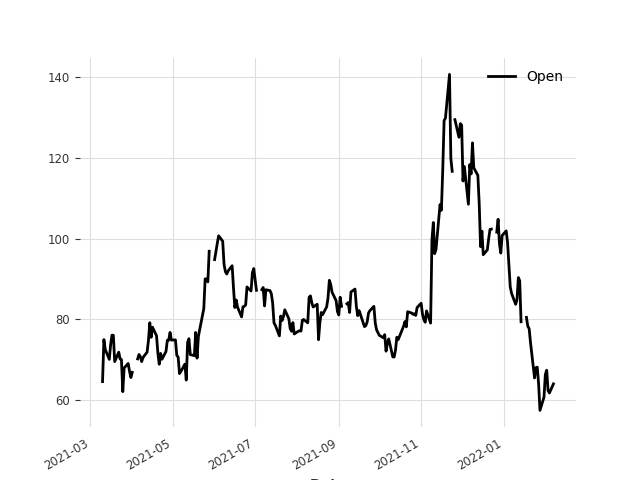

In [3]:
from os.path import abspath
from darts import TimeSeries

# Read /data/RBLX.csv as a pandas dataframe
df = pd.read_csv(abspath('../../data/Roblox/RBLX.csv'), index_col=0)

# Convert the Data column to datetime
df.index = pd.to_datetime(df.index)

series = TimeSeries.from_dataframe(df, value_cols='Open', freq='B')
series = series.astype(np.float32)
# Plot the series using a line graph
series.plot()

In [4]:
from darts.dataprocessing.transformers import Scaler

# Find the timestamp of the first 80% of df
first_80_percent = df.index[int(len(df) * 0.8)]

# Create training and test sets
train, val = series.split_after(pd.Timestamp(first_80_percent))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [7]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import TFTModel

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

input_chunk_length = 48
forecast_horizon = 24

model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=True,
    add_encoders=None,
    model_name = 'Roblox-Noncovariant',
    work_dir = abspath('../../logs/TFT-Noncovariant'),
    log_tensorboard = abspath('../../logs/TFT-Noncovariant/Logs'),
    save_checkpoints = True,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [stopper]}
)

TypeError: __init__() got an unexpected keyword argument 'pl_trainer_kwargs'

In [ ]:
model.fit(train_transformed, verbose=True)